# Medicare Claims Analysis

Medicare is USA's largest government insurance program. It caters to US senior citizens aged 65+, and youths with disabilities. The program is adminstered by CMS (Center for Medicare and Medicaid Services). The data linked is from the CMS Website.


### Guidelines for the task
- Take the time to understand the business problem and to develop a thoughtful solution, we suggest taking a few hours to complete the task.
- Be prepared to talk through what you did during the task to a technical & non-technical audience.
- If there are parts of this EDA that you would do differently, or with more time, would try something else, please discuss these during the interview. 
- Please share code & relevant materials (slides, workbooks etc..) at least 24 hours prior to the interview



### Central Question: How does cost vary across different providers for different conditions?

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
%run helper_functions.py
%load_ext autoreload

In [3]:
slide_background_color = SLIDE_BACKGROUND_COLOR
def set_preferred_options():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
    plt.style.use('dark_background')
    plt.facecolor=(slide_background_color)
    matplotlib.rcParams['font.sans-serif'] = "Arial"
    matplotlib.rcParams['font.family'] = "sans-serif"
    # To suppress a setting with copy warning
    # https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
    pd.options.mode.chained_assignment = None 
set_preferred_options()

### 1 Read the data

In [4]:
def get_data(file_path, char_columns):
    dtype_options = {column: "str" for column in char_columns}
    df = pd.read_csv(file_path, dtype=dtype_options)
    return df

In [5]:
beneficiary_file_path = "./data/DE1_0_2009_Beneficiary_Summary_File_Sample_20.csv"
char_columns_in_beneficiary_data = [
    'BENE_SEX_IDENT_CD',
    'BENE_RACE_CD',
    'BENE_ESRD_IND',
    'SP_STATE_CODE',
    'SP_ALZHDMTA',
    'SP_CHF',
    'SP_CHRNKIDN',
    'SP_CNCR',
    'SP_COPD',
    'SP_DEPRESSN',
    'SP_DIABETES',
    'SP_ISCHMCHT',
    'SP_OSTEOPRS',
    'SP_RA_OA',
    'SP_STRKETIA'
]	


claims_file_path = "./data/DE1_0_2008_to_2010_Outpatient_Claims_Sample_20.csv"
char_columns_in_claims_data = [
    'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2',
    'ICD9_DGNS_CD_3','ICD9_DGNS_CD_4' ,'ICD9_DGNS_CD_5',
    'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8',
    'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10',
    'ICD9_PRCDR_CD_1', 'ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3',
    'ICD9_PRCDR_CD_4', 'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6'     
]



In [6]:
beneficiary_df = get_data(beneficiary_file_path, 
                          char_columns_in_beneficiary_data)
claims_df = get_data(claims_file_path,
                     char_columns_in_claims_data)

In [7]:
beneficiary_df = get_beneficiary_age(beneficiary_df,
                                     'BENE_BIRTH_DT',
                                     reference_date_str='20101212'
                                     )


### 2 Descriptive Graphs

In [8]:
matplotlib.__version__

'3.3.4'

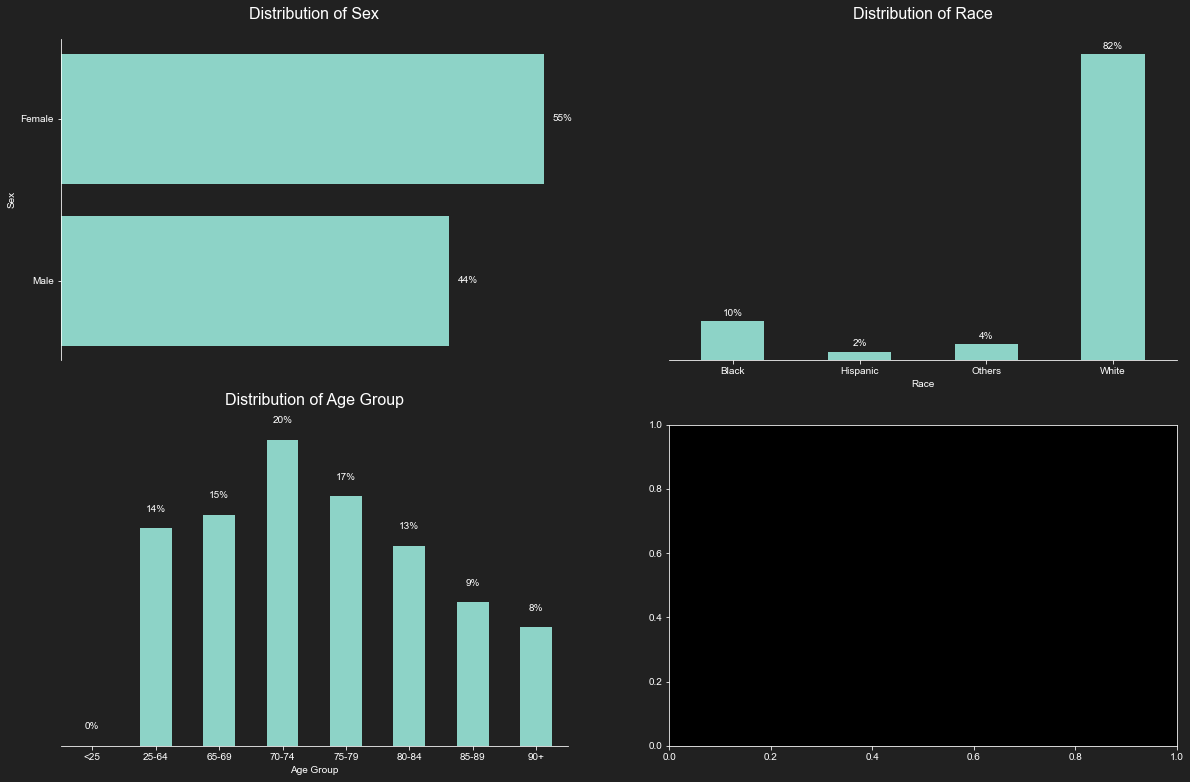

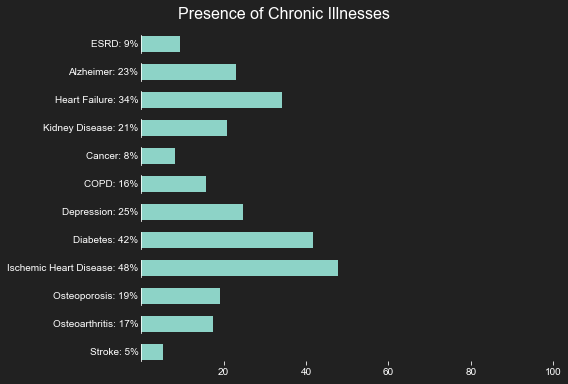

In [9]:
def generate_descriptive_graphs_beneficiary(beneficiary_df):
    sex_labels = {'1':'Male', '2':'Female'}
    race_labels = {'1': 'White', '2': 'Black', '3': 'Others', '5': 'Hispanic'}
    sp_conditions_map = {
    'Yes':'1',
    'No':'2'
    }
    esrd_conditions_map = {
        'No':'0',
        'Yes':'Y'
    }
    conditions_readable_map = {
        'BENE_ESRD_IND':['ESRD', esrd_conditions_map],
        'SP_ALZHDMTA':['Alzheimer', sp_conditions_map],
        'SP_CHF':['Heart Failure', sp_conditions_map],
        'SP_CHRNKIDN':['Kidney Disease', sp_conditions_map],
        'SP_CNCR':['Cancer', sp_conditions_map],
        'SP_COPD':['COPD', sp_conditions_map],
        'SP_DEPRESSN':['Depression', sp_conditions_map],
        'SP_DIABETES':['Diabetes', sp_conditions_map],
        'SP_ISCHMCHT':['Ischemic Heart Disease', sp_conditions_map],
        'SP_OSTEOPRS':['Osteoporosis', sp_conditions_map],
        'SP_RA_OA':['Osteoarthritis', sp_conditions_map],
        'SP_STRKETIA':['Stroke' , sp_conditions_map],
    }

    age_labels = {
        '1': '<25',
        '2': '25-64',
        '3': '65-69',
        '4': '70-74',
        '5': '75-79',
        '6': '80-84',
        '7': '85-89',
        '8': '90+',
    }
    fig, axs = plt.subplots(
        nrows=2,
        ncols=2,
        figsize=(20, 13),
        facecolor=slide_background_color
    )

    generate_horizontal_bar_graph(ax=axs[0, 0],
                                  df=beneficiary_df, 
                                  categorical_variable="BENE_SEX_IDENT_CD",
                                  chart_title="",
                                  variable_readable="Sex",
                                  variable_labels=sex_labels)
    
    generate_vertical_bar_graph(ax=axs[0, 1],
                                df=beneficiary_df, 
                                variable="BENE_RACE_CD",
                                chart_title="",
                                variable_readable="Race",
                                variable_labels=race_labels)
    
    generate_vertical_bar_graph(ax=axs[1, 0],
                                df=beneficiary_df, 
                                variable="age_group",
                                variable_readable="Age Group",
                                chart_title="",
                                variable_labels=age_labels)
    plt.show()
    generate_conditions_summary(beneficiary_df, conditions_readable_map)
    
generate_descriptive_graphs_beneficiary(beneficiary_df)

### 3 Data Quality checks

- Beneficiary data is unique at `DESYNPUF_ID` - which represents the beneficiary code/ patient code according to documentation${^1}$

- The claims data is not unique on `CLM_ID`. However it is unique at `CLM_ID` x `Segment` level.
Wherever segment = 2, most of the variables are `NaN`s, excepting Provider Institution. From looking at this data, my hypothesis is that the claims were amended, with a new Provider Info, or claim amount. For this analysis, I'm dropping the rows where the segment = 2, and most of the variables are `NaN`

- There are some claims where the `CLM_PMT_AMT` is negative, which can occur in
the following cases:
    - Where the beneficiary is charged a coinsurance amount and this is higher than the amount Medicare pays
    - Where the deductible exceeds the amount Medicare pays
    
    In both the above situations the claim amount does not represent the cost of the treatment, hence this has been removed from the dataset

- `MEDREIMB_OP` in the beneficiary dataset denotes the total annual medical Outpatient Reimbursement from Medicaid. There are some beneficiaries in the dataset that have negative due to similar reasons as for `CLM_PMT_AMT`. However these are not removed, as their could be non-negative claim amounts from the same benficiary. I've replaced negative values with
0 for this dataset.



In [10]:
duplicate_claims = claims_df[claims_df.duplicated(subset=['CLM_ID'], keep=False)]
print(f"Percentage of data removed due to duplicates:\
      {round(100* len(duplicate_claims)/len(claims_df), 2)}")

claims_df = claims_df.drop_duplicates(subset=['CLM_ID'])
claims_df = claims_df[claims_df['CLM_PMT_AMT'] >= 0]

beneficiary_df['MEDREIMB_OP'] = beneficiary_df['MEDREIMB_OP'].clip(lower=0)



Percentage of data removed due to duplicates:      2.73


### 4 New column creation
#### 4.1 For illness condition

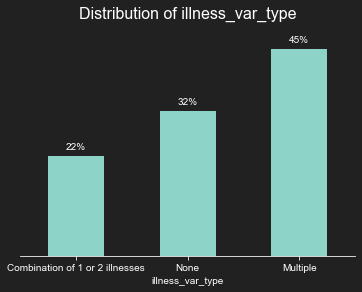

In [11]:
sp_conditions_map = {
'Yes':'1',
'No':'2'
}
esrd_conditions_map = {
    'No':'0',
    'Yes':'Y'
}
conditions_readable_map = {
    'BENE_ESRD_IND':['ESRD', esrd_conditions_map],
    'SP_ALZHDMTA':['Alzheimer', sp_conditions_map],
    'SP_CHF':['Heart Failure', sp_conditions_map],
    'SP_CHRNKIDN':['Kidney Disease', sp_conditions_map],
    'SP_CNCR':['Cancer', sp_conditions_map],
    'SP_COPD':['COPD', sp_conditions_map],
    'SP_DEPRESSN':['Depression', sp_conditions_map],
    'SP_DIABETES':['Diabetes', sp_conditions_map],
    'SP_ISCHMCHT':['Ischemic Heart Disease', sp_conditions_map],
    'SP_OSTEOPRS':['Osteoporosis', sp_conditions_map],
    'SP_RA_OA':['Osteoarthritis', sp_conditions_map],
    'SP_STRKETIA':['Stroke' , sp_conditions_map],
}


beneficiary_df['combined_condition'] = beneficiary_df.apply(combine_conditions, 
                                    columns_to_combine=conditions_readable_map, 
                                    axis=1)
beneficiary_df['combined_condition'].value_counts()
beneficiary_df = get_illness_var_type(beneficiary_df)
generate_vertical_bar_graph(df=beneficiary_df, 
                        variable="illness_var_type")


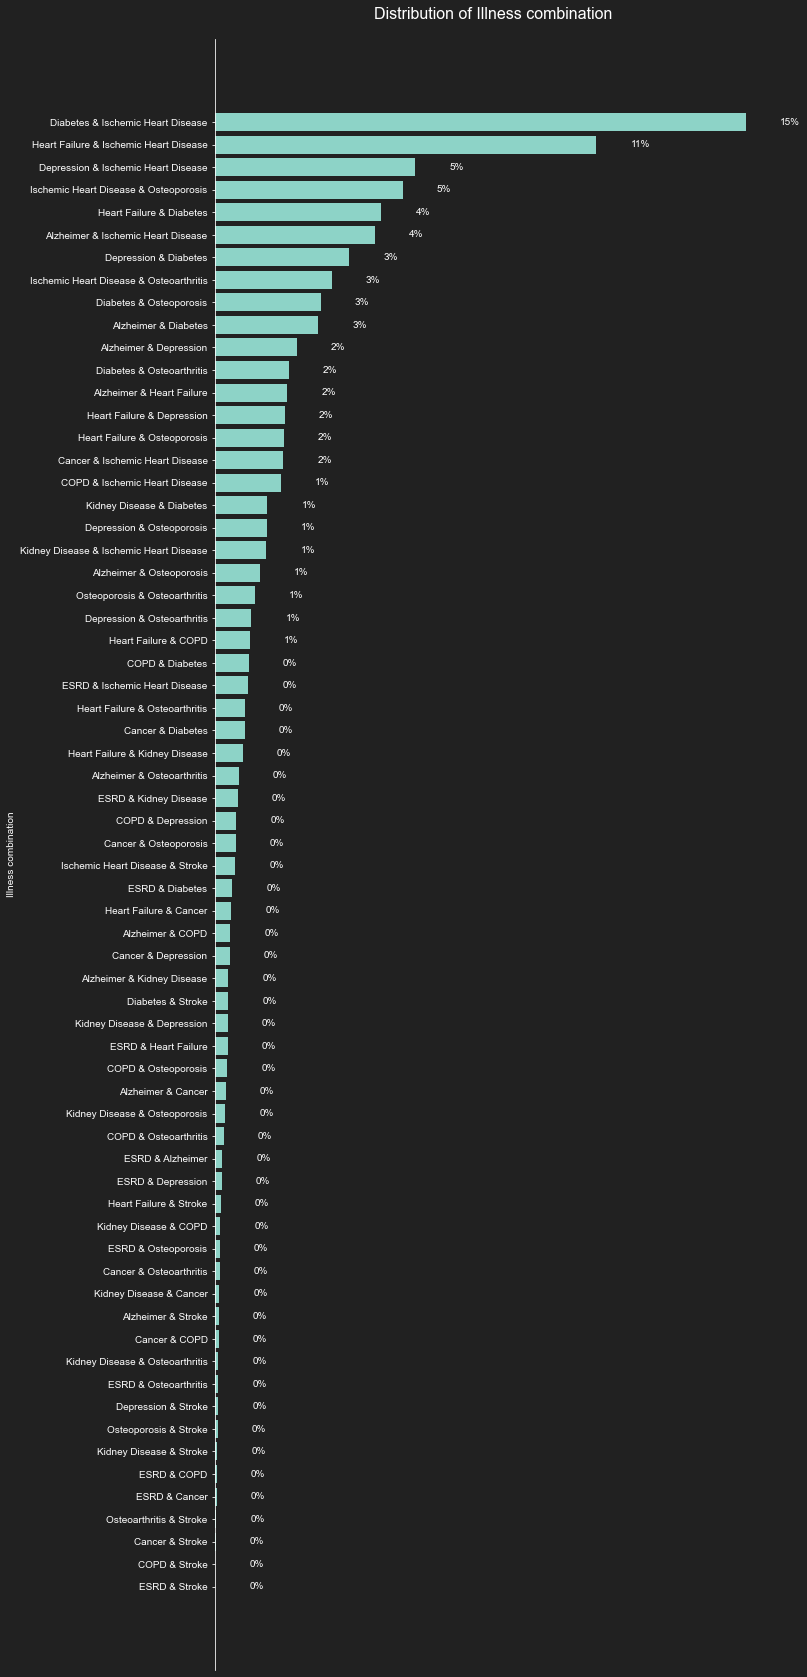

In [12]:
illness_combination_df = beneficiary_df[
    beneficiary_df['combined_condition'].str.contains('\&')
    ]
fig, ax = plt.subplots(figsize=(10, 30), facecolor=SLIDE_BACKGROUND_COLOR)
generate_horizontal_bar_graph(ax=ax,
                              df=illness_combination_df,
                              categorical_variable="combined_condition", 
                              chart_title="", 
                              variable_readable="Illness combination")
plt.show()

### 5 Data join

In [13]:
print(f"# of rows in beneficiary data: {len(beneficiary_df)}")
print(f"# of rows in claims data:  {len(claims_df)}")
beneficiary_claims_df = pd.merge(beneficiary_df, claims_df, 
                                 on='DESYNPUF_ID', how='inner')
print(f'# of rows in joined data: {len(beneficiary_claims_df)}')

# of rows in beneficiary data: 114641
# of rows in claims data:  776670
# of rows in joined data: 774693


In [14]:
merged_df = pd.merge(beneficiary_df, claims_df, on='DESYNPUF_ID', how='outer', indicator=True)

claims_missing_beneficiary = merged_df[merged_df['_merge'] == 'right_only']
beneficiary_missing_claims = merged_df[merged_df['_merge'] == 'left_only']
print(f"Beneficiaries without claims: {len(beneficiary_missing_claims)}")
print(f" %Beneficiaries without claims:\
      {round(100 * len(beneficiary_missing_claims)/len(beneficiary_df), 2)}")
print(f"Claims without beneficiaries: {len(claims_missing_beneficiary)}")
print(f" %Claims without beneficiaries:\
      {round(100 * len(claims_missing_beneficiary)/len(claims_df), 2)}")

Beneficiaries without claims: 30077
 %Beneficiaries without claims:      26.24
Claims without beneficiaries: 1977
 %Claims without beneficiaries:      0.25


In [15]:
beneficiary_missing_claims['TOTAL_SUM'] = (
    beneficiary_missing_claims['MEDREIMB_IP'] + 
    beneficiary_missing_claims['MEDREIMB_CAR']
)

conditions = [
    beneficiary_missing_claims['TOTAL_SUM'] > 0,
    beneficiary_missing_claims['combined_condition'] == 'None'
]

choices = [
    "Has other claims",
    "No illnesses"
]

beneficiary_missing_claims.loc[:, 'missing_reason'] = np.select(
    conditions, choices, default="Missing claims")

print(beneficiary_missing_claims['missing_reason']
      .value_counts(normalize=True) * 100)


No illnesses       68.41
Has other claims   31.17
Missing claims      0.42
Name: missing_reason, dtype: float64


#### 5.1 Data quality after join
- 26% of beneficiaries do not have any Out patient claims, 68% of them 
has no chronic illness, and another 31% have had Medicare reimbursements in 
other type of claims such as In-patient, or prescription costs. This leaves <1%
that do not have any claims and have had some illness.
- There are ~2k OP claims without beneficiaries, which is 0.25% of the data.

Onward with the remaining analysis!

#### 5.2 Data Summary after join


In [16]:
def get_cost_per_member(df, 
                        variable_name='cost_per_member'):
    '''
    Given a dataframe,
    adds a column for cost_per_member
    '''
    df[variable_name] = (df['total_cost']/
                         df['beneficiary_count'])
    df = df.sort_values(by=variable_name, 
                        ascending=False) 
    return df

##### 5.2.1 Cost per Member

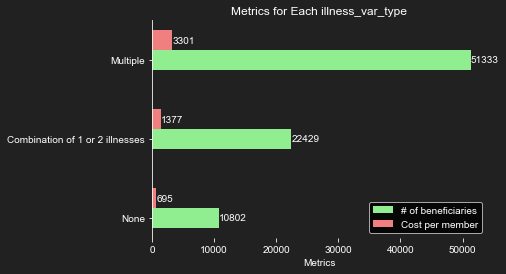

In [17]:
condition_type_grouped_df = (beneficiary_claims_df
                             .groupby('illness_var_type')
                             .agg(
                                total_cost=('CLM_PMT_AMT', 'sum'),
                                beneficiary_count=('DESYNPUF_ID', 'nunique'),  
                                claim_count=('CLM_ID', 'count')  
                                )
                             .reset_index())

condition_type_grouped_df = get_cost_per_member(condition_type_grouped_df,
                                                'cost_per_member_per_illness')
fig, ax = plt.subplots(figsize=(6, 4), facecolor=SLIDE_BACKGROUND_COLOR)
generate_clustered_column(condition_type_grouped_df,
                          'illness_var_type', 
                          'cost_per_member_per_illness', 
                          'Cost per member',
                          'beneficiary_count',
                          '# of beneficiaries',
                          ax)
for i, v in enumerate(condition_type_grouped_df['beneficiary_count']):
   ax.text(v + 1,
            i + 0.25, 
            f'{int(v)}', 
            ha='left', 
            va='center',
            fontsize=10)



##### 5.2.2 Illness combination with highest cost

##### 5.2.3 Illness combination with highest cost per member

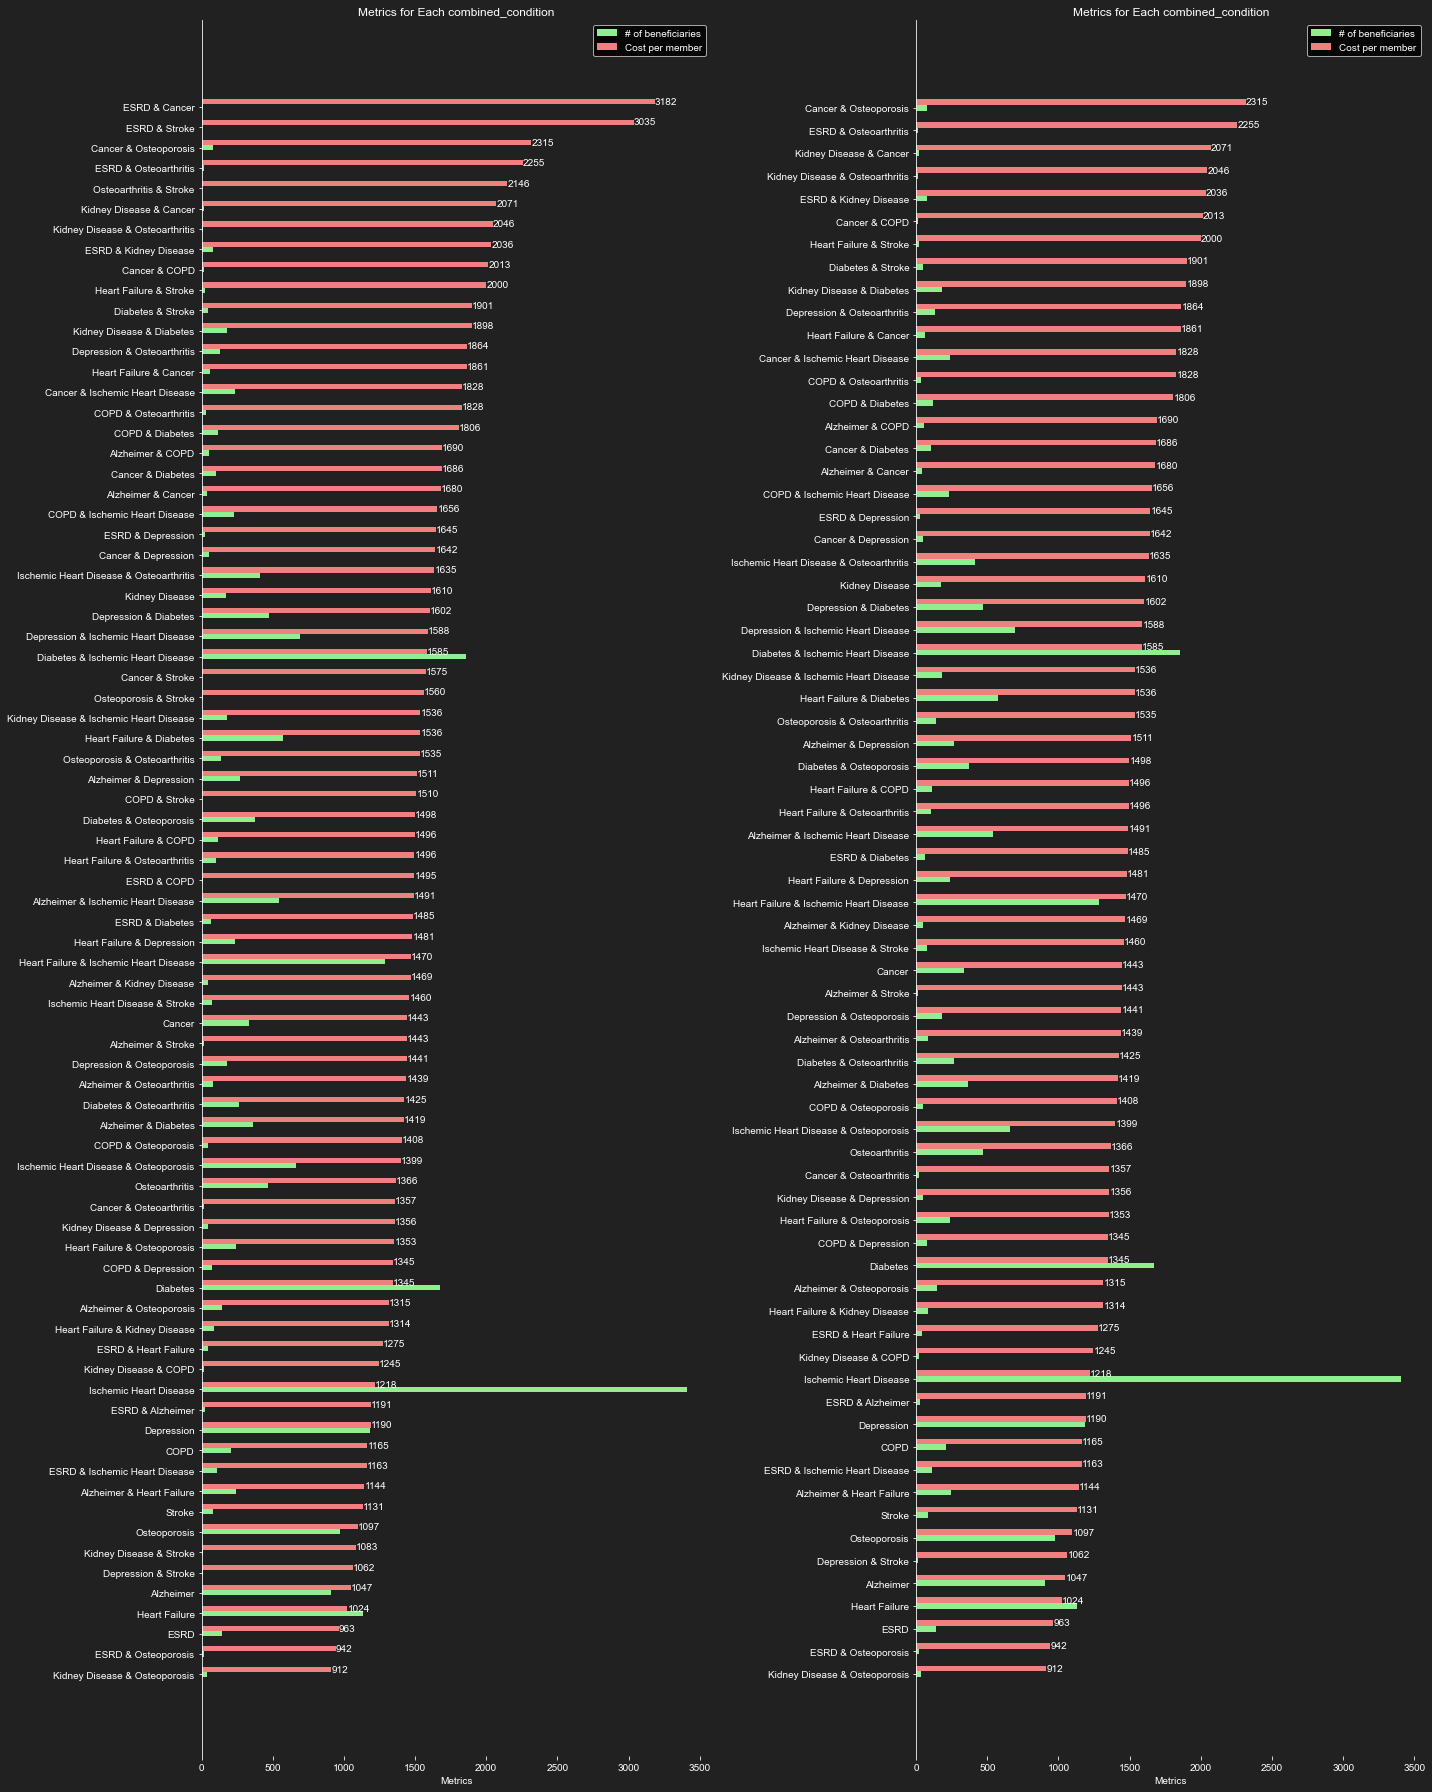

In [18]:

condition_grouped_df = beneficiary_claims_df.groupby('combined_condition').agg(
    total_cost=('CLM_PMT_AMT', 'sum'),
    beneficiary_count=('DESYNPUF_ID', 'nunique'),  
    claim_count=('CLM_ID', 'count')  
).reset_index()

condition_grouped_df = get_cost_per_member(condition_grouped_df,
                                           'cost_per_member_per_illness')


condition_grouped_df_comb2 = get_2combination_illness(condition_grouped_df)


fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(20, 25),
    facecolor=SLIDE_BACKGROUND_COLOR
)

generate_clustered_column(condition_grouped_df_comb2,
                          'combined_condition', 
                          'cost_per_member_per_illness', 
                          'Cost per member',
                          'beneficiary_count',
                          '# of beneficiaries',
                          ax=axs[0])

threshold = condition_grouped_df_comb2['beneficiary_count'].quantile(.10)

condition_grouped_df_comb2_filtered = subset_df_with_greater_than(
    condition_grouped_df_comb2,
    'beneficiary_count',
    threshold)

generate_clustered_column(condition_grouped_df_comb2_filtered,
                          'combined_condition', 
                          'cost_per_member_per_illness', 
                          'Cost per member',
                          'beneficiary_count',
                          '# of beneficiaries',
                          ax=axs[1])
plt.tight_layout()
plt.show()

In [20]:
# # import plotly.express as px

# # Scatter plot using Plotly Express
# fig = px.scatter(condition_grouped_df_comb2, 
#                  x='cost_per_member_per_illness', 
#                  y='beneficiary_count', 
#                  labels={'cost_per_member_per_illness': 'Cost per Member per Illness',
#                          'beneficiary_count': 'Beneficiary Count'},
#                  title='Scatter Plot of Cost per Member per Illness vs. Beneficiary Count',
#                  hover_data=['combined_condition'])

# # # Add a threshold line
# threshold = condition_grouped_df_comb2['beneficiary_count'].quantile(.05)
# fig.add_shape(type='line', x0=condition_grouped_df_comb2['cost_per_member_per_illness'].min(), x1=condition_grouped_df_comb2['cost_per_member_per_illness'].max(), y0=threshold, y1=threshold, line=dict(color='red', dash='dash'))

# fig.update_layout(showlegend=False)
# # Show the plot
# fig.show()




### 6 Benchmarking

The aim here is to understand the distribution of cost across providers treating members with these chronic illnesses. Benchmarking providers across types of care is often a helpful starting point to begin solutioning for areas of high cost.

For each provider (use AT_PHYSN_NPI) & chronic illness, calculate the cost per member.
For each chronic illness combination, represent the distribution of costs per provider.
How does this change if we filter out cases where a given Chronic Illness & Provider NPI combination only has 1 member?
Which providers are consistently expensive across chronic illnesses they treat?


In [21]:
provider_condition_grouped_df = (beneficiary_claims_df
                                 .groupby(['AT_PHYSN_NPI', 'combined_condition'])
                                 .agg(total_cost=('CLM_PMT_AMT', 'sum'),
                                     beneficiary_count=('DESYNPUF_ID', 'nunique'),
                                    )
                                ).reset_index()


provider_condition_grouped_df = get_cost_per_member(
    provider_condition_grouped_df,
    'cost_per_member_per_provider_per_illness')


#### 6.1 Distribution of Cost per member across providers

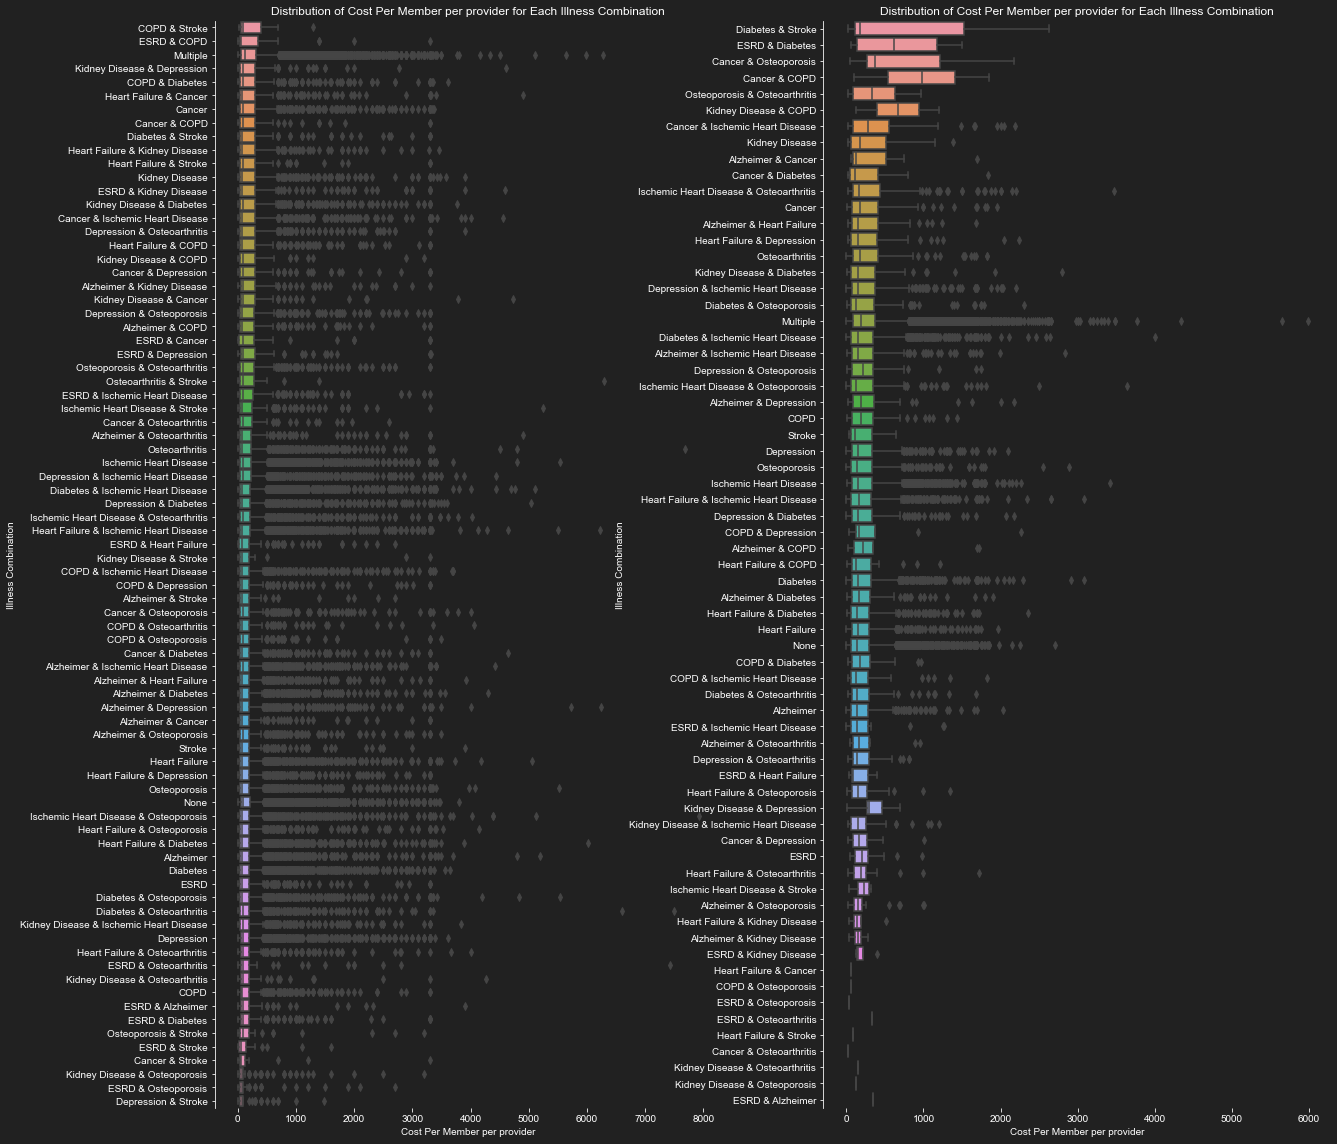

In [22]:

fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(20, 20),
    facecolor=SLIDE_BACKGROUND_COLOR
)
generate_boxplot(provider_condition_grouped_df,
                 'combined_condition',
                 'Illness Combination',
                 'cost_per_member_per_provider_per_illness',
                 'Cost Per Member per provider', axs[0])
provider_condition_grouped_df_filtered = subset_df_with_greater_than(
    provider_condition_grouped_df,
    'beneficiary_count',
    1)
                                        
generate_boxplot(provider_condition_grouped_df_filtered,
                 'combined_condition',
                 'Illness Combination',
                 'cost_per_member_per_provider_per_illness',
                 'Cost Per Member per provider', 
                 axs[1])

# Show the plot
plt.show()


#### 6.2 Solution 1:
Irrespective of illness, retrieve providers that cost more than 75th percentile

In [23]:
provider_grouped_df = (
    beneficiary_claims_df
    .groupby('AT_PHYSN_NPI')
    .agg(
        total_cost=('CLM_PMT_AMT', 'sum'),
        beneficiary_count=('DESYNPUF_ID', 'nunique')
        ).reset_index()
)

provider_grouped_df = get_cost_per_member(provider_grouped_df,
                                          'cost_per_member_per_provider')

provider_grouped_df.describe()

,AT_PHYSN_NPI,total_cost,beneficiary_count,cost_per_member_per_provider
count,97815.00,97815.00,97815.00,97815.00
mean,5001112761.38,1961.00,6.19,264.88
std,2880706704.14,8988.40,20.26,405.38
min,102408.00,0.00,1.00,0.00
25%,2514044308.00,80.00,1.00,57.50
50%,5007034132.00,300.00,2.00,120.00
75%,7484742522.00,1260.00,4.00,300.00
max,9999658129.00,723600.00,1051.00,6270.00


In [24]:
threshold_cpm_per_provider = provider_grouped_df['cost_per_member_per_provider'].quantile(0.95)
threshold_cpm_per_provider

940.0

In [25]:
temp_df = subset_df_with_greater_than(provider_grouped_df, 
                                      'cost_per_member_per_provider',
                                      threshold_cpm_per_provider)
temp_df = subset_df_with_greater_than(temp_df,
                                      'beneficiary_count',
                                      1)
temp_df.describe()
# threshold_cpm_per_provider = temp_df['cost_per_member_per_provider'].quantile(0.99)
# temp_df[temp_df['cost_per_member_per_provider'] > threshold_cpm_per_provider].describe()

,AT_PHYSN_NPI,total_cost,beneficiary_count,cost_per_member_per_provider
count,2147.00,2147.00,2147.00,2147.00
mean,4834954027.74,4791.43,3.84,1312.66
std,2874762289.71,9152.60,8.00,352.51
min,1159725.00,1890.00,2.00,942.22
25%,2374565683.50,2595.00,2.00,1057.50
50%,4778886360.00,3350.00,2.00,1200.00
75%,7287097888.00,3900.00,3.00,1502.50
max,9986336677.00,187110.00,188.00,5980.00


In [33]:
# temp_df contains those providers that charge its members highly
# what if we moved each of these members to the  90 percentile value
temp_df['new_cost_per_member_provider'] = (temp_df['cost_per_member_per_provider']
                                           .clip(upper=1500))
temp_df['new_total_cost'] = (temp_df['new_cost_per_member_provider'] 
                             * temp_df['beneficiary_count'])
perc_difference_in_total_cost = (1 - 
                                 temp_df['new_total_cost'].sum()/
                                 temp_df['total_cost'].sum() )
print(f'Perc difference in total cost: {round(100 * perc_difference_in_total_cost)}')

Perc difference in total cost: 4


In [34]:
beneficiary_claims_df['claim_year'] = (
    pd.to_datetime(beneficiary_claims_df['CLM_THRU_DT'],
                   format='%Y%m%d')
                   .dt.year
)
mean_yearly_cost = (beneficiary_claims_df
               .groupby('claim_year')
               .agg(total_cost=('CLM_PMT_AMT', 'sum'))
               .reset_index())['total_cost'].mean()


In [35]:
potential_annual_savings = perc_difference_in_total_cost * mean_yearly_cost *(1 / 0.05)
print(f'Potential annual savings: {potential_annual_savings:,.0f}')

Potential annual savings: 53,242,958


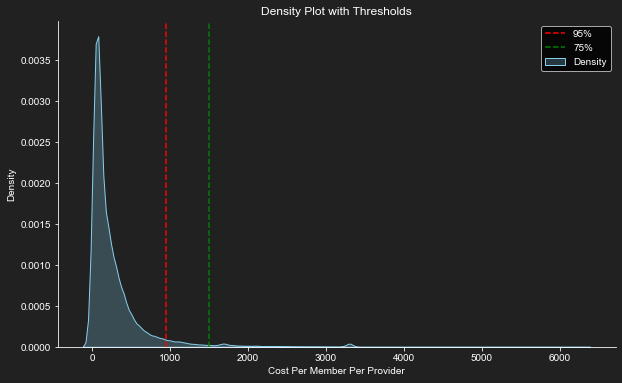

In [42]:
data = provider_grouped_df['cost_per_member_per_provider']


line_value1 = 1500

# Create the density plot

fig, ax = plt.subplots(figsize=(10, 6), facecolor=SLIDE_BACKGROUND_COLOR)

sns.kdeplot(data, fill=True, color='skyblue', label='Density')

# Add vertical lines at the threshold and line_value1
plt.axvline(x=threshold_cpm_per_provider, color='red', linestyle='--', label='95%')
plt.axvline(x=line_value1, color='green', linestyle='--', label='75%')

# Set labels and title
plt.xlabel('Cost Per Member Per Provider')
plt.ylabel('Density')
plt.title('Density Plot with Thresholds')

ax.spines['top'].set_visible(False)   
ax.spines['right'].set_visible(False) 
ax.set_facecolor(SLIDE_BACKGROUND_COLOR) 


plt.legend()
plt.show()


In [28]:
grouped_stats_df = pd.merge(provider_condition_grouped_df, condition_grouped_df, on=['combined_condition'])
# grouped_stats_df = grouped_stats_df.drop(['total_cost', 'beneficiary_count', 'claim_count'], axis=1)
grouped_stats_df['diff'] = grouped_stats_df['cost_per_member_per_illness'] - grouped_stats_df['cost_per_member_per_provider']
grouped_stats_df
grouped_stats_df = grouped_stats_df[grouped_stats_df['beneficiary_count_x'] > 1]

grouped_stats_df.sort_values(by=['AT_PHYSN_NPI','diff'], ascending=False)

KeyError: 'cost_per_member_per_provider'

In [ ]:
grouped_stats = (filtered_df
                 .groupby(['AT_PHYSN_NPI', 'combined_condition'])['cost_per_member']
                 .agg(['mean', 'median', 'std', 'count'])
                 .reset_index())
grouped_stats_df = pd.merge(grouped_stats, condition_grouped_df, on=['combined_condition'])
# grouped_stats_df = grouped_stats_df.drop(['total_cost', 'beneficiary_count', 'claim_count'], axis=1)
grouped_stats_df['diff'] = grouped_stats_df['median'] - grouped_stats_df['cost_per_member']


grouped_stats_df.sort_values(by=['diff'], ascending=False)

            

In [ ]:
# Filter groups with count greater than 1
grouped_stats_filtered = grouped_stats_df[grouped_stats_df['count'] > 1]

# Reset index after filtering
grouped_stats_filtered = grouped_stats_filtered.reset_index(drop=True)
grouped_stats_filtered.sort_values(by=['diff'], ascending=False)

In [ ]:
average_cost_per_provider = provider_condition_grouped_df.groupby(['AT_PHYSN_NPI', 'combined_condition'])['cost_per_member_per_provider'].median().reset_index()

# Step 2: Identify providers with consistently high average costs across chronic illnesses
consistently_expensive_providers = average_cost_per_provider.groupby('AT_PHYSN_NPI')['cost_per_member_per_provider'].median().sort_values(ascending=False)

# Display the results
print(consistently_expensive_providers.head(50))

In [ ]:
member_grouped_df = (beneficiary_claims_df
                     .groupby(['DESYNPUF_ID', 'combined_condition'])
                     .agg(physician_count=('AT_PHYSN_NPI', 'nunique'),
                          cost=('CLM_PMT_AMT', 'sum')
                          )
                    )


# (member_grouped_df
#  .groupby(['combined_condition'])
#  .agg(num_physicians=('physician_count', 'sum'),
#       median_cost_per_member_per_illness=('cost', 'median') 
#       )
#  )

In [ ]:
from scipy.stats import percentileofscore

# Assuming you have a DataFrame provider_condition_grouped_df

# Calculate the percentile for each row
provider_condition_grouped_df['percentile'] = provider_condition_grouped_df.groupby('AT_PHYSN_NPI')['cost_per_member'].apply(
    lambda x: x.apply(lambda y: percentileofscore(x, y))
)

# Calculate the median cost per member across providers for each combined_condition
provider_condition_grouped_df['median_cost_per_member_across_providers'] = provider_condition_grouped_df.groupby('combined_condition')['cost_per_member'].transform('median')

provider_condition_grouped_df

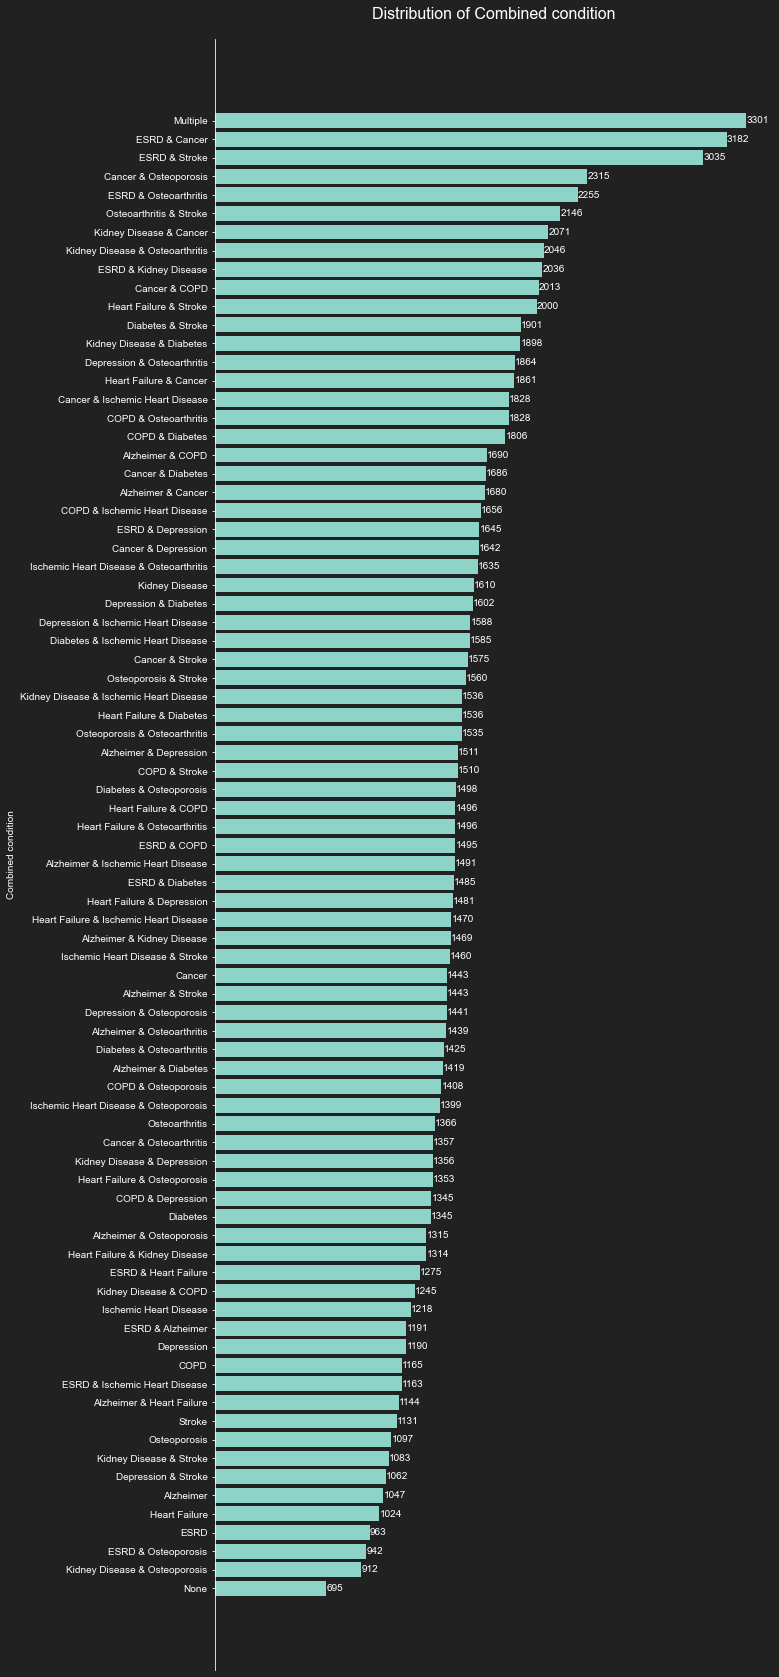

In [22]:

(condition_grouped_df
 .sort_values(
     by='cost_per_member_per_illness', 
     ascending=True, 
     inplace=True)
     )

fig, ax = plt.subplots(figsize=(10, 30), facecolor=SLIDE_BACKGROUND_COLOR)

generate_horizontal_bar_graph(df=condition_grouped_df,
                              categorical_variable='combined_condition',
                              variable_x='cost_per_member_per_illness',
                              chart_title='Cost Per Member for various Combined Conditions',
                              ax=ax,
                              variable_readable='Combined condition')
plt.show()



### References
1. CMS Linkable 2008–2010 Medicare DE-SynPUF [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/SynPUF_DUG.pdf]
2. Codebook for CMS Linkable 2008–2010 Medicare DE-SynPUF [https://www.cms.gov/files/document/de-10-codebook.pdf-0]
3. Race and Ethnicity in the US [https://www.census.gov/library/visualizations/interactive/race-and-ethnicity-in-the-united-state-2010-and-2020-census.html]